In [1]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import re
import os
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import unicodedata
try:
    import emoji
except Exception:
    emoji = None

try:
    from bs4 import BeautifulSoup
except Exception:
    BeautifulSoup = None
import nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")

from nltk.corpus import stopwords
import unicodedata

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
train = pd.read_csv('data/multiclass_sentiment_analysis_dataset_train.csv')
test = pd.read_csv('data/multiclass_sentiment_analysis_dataset_test.csv')
valid = pd.read_csv('data/multiclass_sentiment_analysis_dataset_validation.csv')

train.shape, test.shape, valid.shape

((31232, 4), (5206, 4), (5205, 4))

In [4]:
df = pd.concat([train, test, valid], axis=0, ignore_index=True)

print(df.shape)

(41643, 4)


In [5]:
train.head()

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [6]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text_light(text: str) -> str:
    if not text:
        return ""
    tokens = TOKEN_RE.findall(text)

    out = []
    for tok in tokens:
        if tok.startswith("<") and tok.endswith(">"):
            out.append(tok)
            continue

        t = tok.lower()

        # heuristic verbs: try verb lemma first, then noun
        v = lemmatizer.lemmatize(t, pos="v")
        n = lemmatizer.lemmatize(v, pos="n")

        out.append(n)

    return " ".join(out)

# ---- stopwords ----
NLTK_STOPWORDS = set(stopwords.words("english"))

# nếu bạn muốn giữ các từ phủ định cho sentiment (khuyến nghị):
# vì "not", "no", "never" rất quan trọng
NEGATION_WORDS = {"no", "nor", "not", "never", "n't"}
NLTK_STOPWORDS_FOR_SENTIMENT = NLTK_STOPWORDS - NEGATION_WORDS


# ---- regex ----
URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
HTML_RE = re.compile(r"<[^>]+>")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
MULTISPACE_RE = re.compile(r"\s+")
NUMBER_RE = re.compile(r"\b\d+(\.\d+)?\b")
REPEAT_PUNCT_RE = re.compile(r"([!?.,])\1{1,}")
REPEAT_CHAR_RE = re.compile(r"(.)\1{3,}")

# token: giữ <URL>, <NUM> + word
TOKEN_RE = re.compile(r"<[^>]+>|[a-zA-Z]+(?:'[a-zA-Z]+)?|\d+", re.UNICODE)


def normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)

def strip_html(text: str) -> str:
    return HTML_RE.sub(" ", text)

def reduce_lengthening(text: str) -> str:
    return REPEAT_CHAR_RE.sub(r"\1\1\1", text)

def reduce_punct(text: str) -> str:
    return REPEAT_PUNCT_RE.sub(r"\1\1", text)

def clean_text_en(
    text,
    lowercase: bool = True,
    remove_html: bool = True,
    remove_url: bool = True,
    remove_email: bool = True,
    normalize_numbers: bool = False,
    mention_mode: str = "mask",     # mask|remove|keep
    hashtag_mode: str = "dehash",   # keep|remove|dehash
    keep_punct: bool = False,       # classic ML: False; Transformers: True
):
    if text is None:
        return ""
    if not isinstance(text, str):
        text = str(text)

    text = normalize_unicode(text)

    if remove_html:
        text = strip_html(text)

    if remove_url:
        text = URL_RE.sub(" <URL> ", text)

    if remove_email:
        text = EMAIL_RE.sub(" <EMAIL> ", text)

    if mention_mode == "mask":
        text = MENTION_RE.sub(" <USER> ", text)
    elif mention_mode == "remove":
        text = MENTION_RE.sub(" ", text)

    if hashtag_mode == "remove":
        text = re.sub(r"#\w+", " ", text)
    elif hashtag_mode == "dehash":
        text = HASHTAG_RE.sub(r"\1", text)

    if normalize_numbers:
        text = NUMBER_RE.sub(" <NUM> ", text)

    if lowercase:
        text = text.lower()

    if not keep_punct:
        # giữ token dạng <URL>, <NUM> bằng cách tách ra trước
        text = re.sub(r"(<[^>]+>)", r" \1 ", text)
        # bỏ punctuation
        text = re.sub(r"[^a-z0-9<_>\s']", " ", text, flags=re.IGNORECASE)

    text = reduce_lengthening(text)
    text = reduce_punct(text)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text


def remove_stopwords_nltk(
    text: str,
    sw_set: set,
    keep_special_tokens: bool = True,
    min_len: int = 1,
):
    if not text:
        return ""

    tokens = TOKEN_RE.findall(text)
    out = []
    for tok in tokens:
        if keep_special_tokens and tok.startswith("<") and tok.endswith(">"):
            out.append(tok)
            continue

        t = tok.lower().strip()
        if len(t) < min_len:
            continue

        if t in sw_set:
            continue

        out.append(tok)

    return " ".join(out)


def preprocess_text_column_en(
    s: pd.Series,
    remove_stopwords: bool = True,
    keep_negations: bool = True,
    keep_punct: bool = False,
    lemmatize_mode: str = "light",   
):
    sw = NLTK_STOPWORDS_FOR_SENTIMENT if keep_negations else NLTK_STOPWORDS

    cleaned = s.apply(lambda x: clean_text_en(x, keep_punct=keep_punct))

    cleaned = cleaned.apply(lemmatize_text_light)  # bản nhẹ

    if remove_stopwords:
        cleaned = cleaned.apply(lambda x: remove_stopwords_nltk(x, sw_set=sw))

    return cleaned


In [7]:
df["text_clean"] = preprocess_text_column_en(df["text"])
df.head()

,id,text,label,sentiment,text_clean
0,9536,"Cooking microwave pizzas, yummy",2,positive,cook microwave pizza yummy
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral,plan allow sub task show widget
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive,love humor reword like say group therapy inste...
3,14182,naw idk what ur talkin about,1,neutral,naw idk ur talkin
4,17840,That sucks to hear. I hate days like that,0,negative,suck hear hate day like


In [8]:
import re
import pandas as pd
from collections import Counter

def top_common_words_across_labels_with_gap(
    df: pd.DataFrame,
    text_col: str = "text_clean",
    label_col: str = "label",
    top_n: int = 50,
    min_len: int = 2,
    min_df_each_label: int = 5,   # "xuất hiện nhiều" ở mỗi label
    max_gap_ratio: float = 0.30,  # <= 30%
):
    labels = [x for x in df[label_col].dropna().unique().tolist()]
    if len(labels) != 3:
        raise ValueError(f"Expected exactly 3 labels, but got {len(labels)}: {labels}")

    token_re = re.compile(r"[a-zA-Z']+")

    # doc-frequency counters: word -> #samples_containing_word (per label)
    df_counters = {lab: Counter() for lab in labels}

    for lab in labels:
        sub = df.loc[df[label_col] == lab, text_col].dropna().astype(str)

        for text in sub:
            # set() => mỗi sample chỉ tính 1 lần cho 1 từ (document frequency)
            words = set(w.lower() for w in token_re.findall(text) if len(w) >= min_len)
            df_counters[lab].update(words)

    # intersection: từ có mặt ở cả 3 labels
    common_words = set(df_counters[labels[0]].keys())
    common_words &= set(df_counters[labels[1]].keys())
    common_words &= set(df_counters[labels[2]].keys())

    def gap_ratio(a: int, b: int) -> float:
        # |a-b| / max(a,b) ; nếu cả hai = 0 thì gap = 0 (nhưng case này không xảy ra do đã lọc)
        m = max(a, b)
        return 0.0 if m == 0 else abs(a - b) / m

    rows = []
    for w in common_words:
        c0 = df_counters[labels[0]][w]
        c1 = df_counters[labels[1]][w]
        c2 = df_counters[labels[2]][w]

        # constraint 1: nhiều ở cả 3 label
        if not (c0 >= min_df_each_label and c1 >= min_df_each_label and c2 >= min_df_each_label):
            continue

        # constraint 2: gap giữa mọi cặp không quá 30%
        g01 = gap_ratio(c0, c1)
        g02 = gap_ratio(c0, c2)
        g12 = gap_ratio(c1, c2)

        if max(g01, g02, g12) > max_gap_ratio:
            continue

        rows.append((
            w, c0, c1, c2,
            c0 + c1 + c2,
            min(c0, c1, c2),
            max(g01, g02, g12)  # mức lệch lớn nhất
        ))

    # sort: ưu tiên từ "đều" nhất + xuất hiện nhiều
    rows.sort(key=lambda x: (x[5], x[4]), reverse=True)

    out = pd.DataFrame(rows[:top_n], columns=[
        "word",
        f"df_in_{labels[0]}",
        f"df_in_{labels[1]}",
        f"df_in_{labels[2]}",
        "df_total",
        "df_min_across_3",
        "max_pair_gap_ratio",
    ])

    return out


# ======= RUN =======
common_df = top_common_words_across_labels_with_gap(
    df,
    text_col="text_clean",
    label_col="label",
    top_n=50,
    min_len=2,
    min_df_each_label=5,
    max_gap_ratio=0.10
)

common_df


,word,df_in_2,df_in_1,df_in_0,df_total,df_min_across_3,max_pair_gap_ratio
0,find,326,338,305,969,305,0.097633
1,set,265,256,262,783,256,0.033962
2,something,192,196,192,580,192,0.020408
3,instead,108,108,111,327,108,0.027027
4,house,90,97,90,277,90,0.072165
5,outside,47,50,46,143,46,0.080000
6,plus,48,44,48,140,44,0.083333
7,decide,43,40,42,125,40,0.069767
8,small,44,40,40,124,40,0.090909
9,connect,33,33,36,102,33,0.083333


In [9]:
remove_words = common_df['word'].to_list()
words = ['app', 'one', 'today', 'time', 'task']
remove_words.extend(words)
remove_words

['find',
 'set',
 'something',
 'instead',
 'house',
 'outside',
 'plus',
 'decide',
 'small',
 'connect',
 'record',
 'todoist',
 'recur',
 'continue',
 'currently',
 'provide',
 'earlier',
 'wife',
 'tablet',
 'glitch',
 'peep',
 'midnight',
 'network',
 'shes',
 'wide',
 'def',
 'awhile',
 'possibly',
 'senior',
 'greg',
 'pin',
 'calander',
 'decrease',
 'popup',
 'app',
 'one',
 'today',
 'time',
 'task']

In [10]:
def remove_words_from_text(text, remove_set, whole_word=True, ignore_case=True):
    if text is None:
        return ""
    if not isinstance(text, str):
        text = str(text)

    words = [w for w in remove_set if w]  # drop empty
    if not words:
        return text

    # normalize to lower if ignore_case
    if ignore_case:
        remove_set = {w.lower() for w in words}
        tokens = text.split()
        kept = [t for t in tokens if t.lower() not in remove_set]
        return " ".join(kept)

    # case-sensitive removal
    tokens = text.split()
    kept = [t for t in tokens if t not in remove_set]
    return " ".join(kept)


# ===== Usage =====
df["text_clean"] = df["text_clean"].apply(lambda x: remove_words_from_text(x, remove_words))


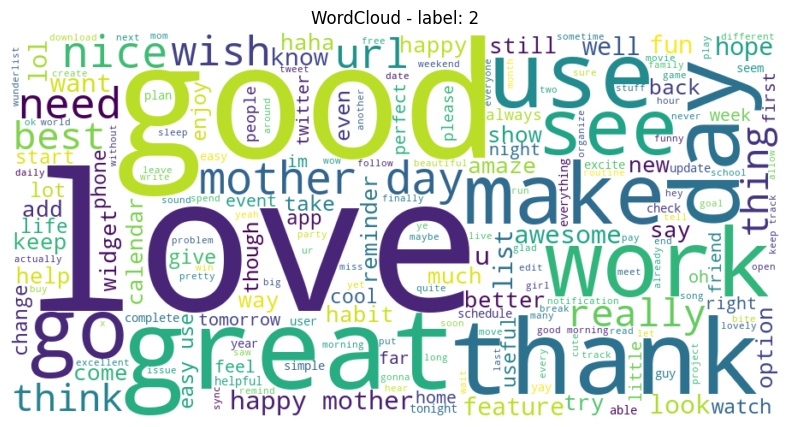

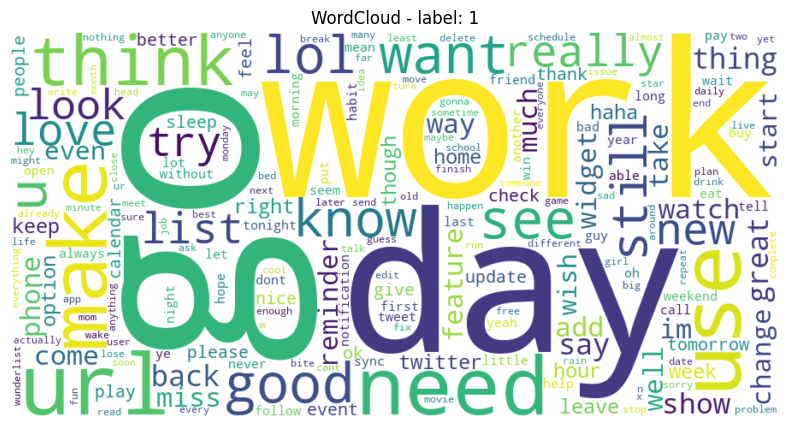

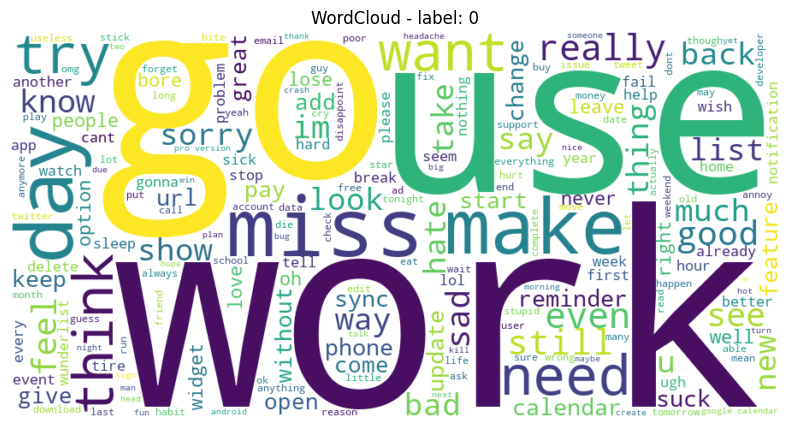

In [11]:
text_col = "text_clean"   
label_col = "label"

for lab in df[label_col].dropna().unique():
    text = " ".join(df.loc[df[label_col] == lab, text_col].dropna().astype(str))
    wc = WordCloud(width=900, height=450, background_color="white").generate(text)

    plt.figure(figsize=(12, 5))
    plt.imshow(np.array(wc.to_image()), interpolation="bilinear")  # <-- key line
    plt.axis("off")
    plt.title(f"WordCloud - label: {lab}")
    plt.show()

In [12]:
col = "text_clean"

df["word_count"] = df[col].fillna("").astype(str).str.split().str.len()
df[[col, "word_count"]].head()

,text_clean,word_count
0,cook microwave pizza yummy,4
1,plan allow sub show widget,5
2,love humor reword like say group therapy gang ...,13
3,naw idk ur talkin,4
4,suck hear hate day like,5


In [13]:
df["word_count"].describe()

count    41643.000000
mean         9.359412
std          8.383629
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max        193.000000
Name: word_count, dtype: float64

In [14]:
df = df[df["word_count"] >= 4].reset_index(drop=True)

In [15]:
df.sort_values("word_count").head(10)[[col, "word_count"]]
df.sort_values("word_count", ascending=True).head(10)[[col, "word_count"]]

,text_clean,word_count
33959,<url> choose wrong career,4
33983,know twitter depress tonight,4
33974,lol fine way weekend,4
53,hope u alright final,4
50,omg madness come radio,4
40,ti 89 die know,4
34014,anticipate tough day ahead,4
21491,love sometimes widget freeze,4
3652,thank gifford lecture page,4
3642,maybe cause look innocent,4


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34030 entries, 0 to 34029
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34030 non-null  int64 
 1   text        34030 non-null  object
 2   label       34030 non-null  int64 
 3   sentiment   34030 non-null  object
 4   text_clean  34030 non-null  object
 5   word_count  34030 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [17]:
from sklearn.model_selection import train_test_split

label_col = "label"

# 1) split train (80%) vs temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[label_col],
)

# 2) split temp (20%) into val (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,          # half of 20% => 10%
    random_state=42,
    stratify=temp_df[label_col],
)

# 3) save
train_df.to_csv("train.csv", index=False)
val_df.to_csv("valid.csv", index=False)
test_df.to_csv("test.csv", index=False)

# (optional) quick check ratios
def ratio(x):
    return x[label_col].value_counts(normalize=True).round(4)

print("Train ratio:\n", ratio(train_df))
print("Valid ratio:\n", ratio(val_df))
print("Test ratio:\n", ratio(test_df))

Train ratio:
 label
1    0.3539
2    0.3438
0    0.3023
Name: proportion, dtype: float64
Valid ratio:
 label
1    0.3541
2    0.3438
0    0.3021
Name: proportion, dtype: float64
Test ratio:
 label
1    0.3538
2    0.3438
0    0.3024
Name: proportion, dtype: float64


In [18]:
import pandas as pd

splits = {"train": train_df, "valid": val_df, "test": test_df}

# Ensure word_count exists (change text_col if needed)
text_col = "text_clean"
for name, d in splits.items():
    if "word_count" not in d.columns:
        d["word_count"] = d[text_col].fillna("").astype(str).str.split().str.len()

# Stats table
stats = pd.DataFrame({
    name: d["word_count"].describe()
    for name, d in splits.items()
}).T

stats

,count,mean,std,min,25%,50%,75%,max
train,27224.0,10.930833,8.404979,4.0,6.0,9.0,12.0,182.0
valid,3403.0,10.925948,8.289184,4.0,6.0,9.0,12.0,89.0
test,3403.0,11.152806,9.271313,4.0,6.0,9.0,13.0,193.0


In [19]:
test_df.head()

,id,text,label,sentiment,text_clean,word_count
5205,22972,"it`s an awesome book, can`t wait for the film...",2,positive,awesome book wait film enjoy scar x,7
17393,19928,"Going out to eat with my entourage, probably t...",1,neutral,go eat entourage probably fat e since close to...,14
28938,21306,stealth shopping - got wife b-day present whil...,1,neutral,stealth shop get b day present mall together n...,14
21383,7130,At the dentist for Hopes first check up. Lets ...,1,neutral,dentist hop first check let handle dentist,7
32661,2754,Had a great weekend... but ate too much I thin...,2,positive,great weekend eat much think look forward trip...,12


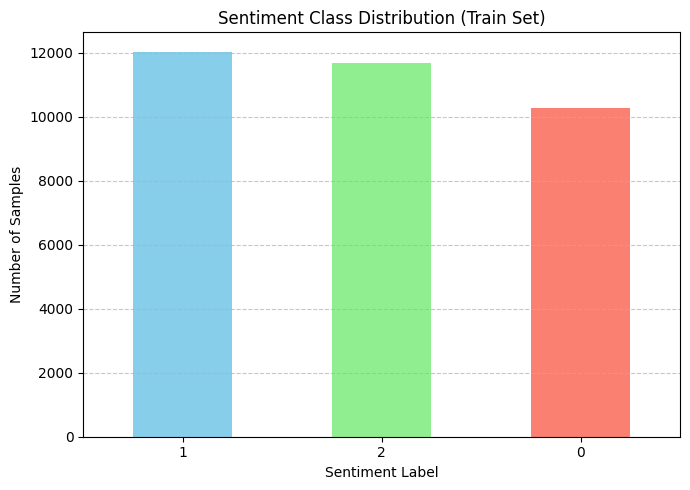

In [20]:
# ---- 1. Sentiment Class Distribution ----
plt.figure(figsize=(7, 5))
df['label'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'lightgreen', 'salmon']
)
plt.title("Sentiment Class Distribution (Train Set)")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("pic/class_distribution.png")
plt.show()


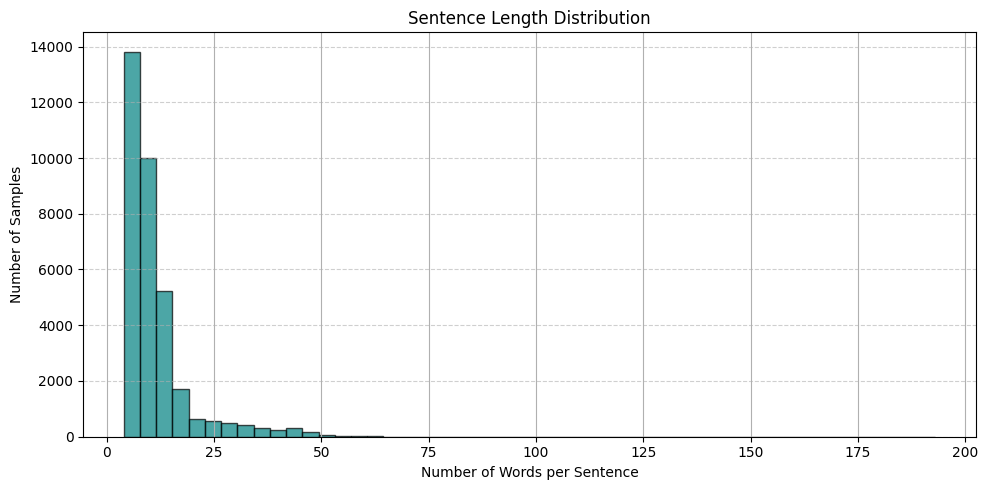

In [22]:
# ---- 2. Sentence Length Distribution ----
plt.figure(figsize=(10, 5))
df["word_count"].hist(
    bins=50,
    color='teal',
    edgecolor='black',
    alpha=0.7
)
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Number of Samples")
plt.title("Sentence Length Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("pic/sentence_length_distribution.png")
plt.show()

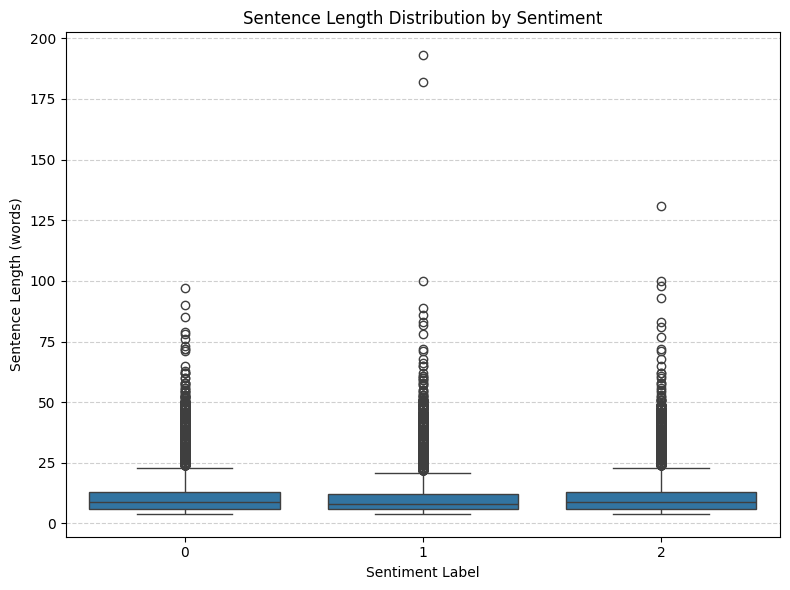

In [23]:
# ---- 3. Sentence Length by Sentiment ----
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="label",
    y="word_count",
)
plt.title("Sentence Length Distribution by Sentiment")
plt.xlabel("Sentiment Label")
plt.ylabel("Sentence Length (words)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("pic/boxplot_sentence_length_by_sentiment.png")
plt.show()